## Introduction

Link/edge prediction demo for cora dataset (homegeneous network) where all nodes are papers and edges between nodes are citation links, e.g., paper A cites paper B. 

Each paper has a **subject** attribute with one of 7 values denoting the subject area of the paper.

This demo notebook **demonstrates how to predict citation links/edges between papers** using the random walk-based representation learning method Node2Vec.

<a name="refs"></a>
**References:** 

[1] Node2Vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016. 

<table><tr><td>Run the master version of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/random-walks/cora-lp-demo.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/random-walks/cora-lp-demo.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]

In [2]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

%matplotlib inline

## Load the dataset

In [3]:
dataset = datasets.Cora()
display(HTML(dataset.description))
graph, _ = dataset.load(largest_connected_component_only=True, str_node_ids=True)

In [4]:
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]


## Construct splits of the input data

We are going to tackle link prediction as a supervised learning problem, where we are going to train a binary classifier to predict a link, or not, between any two nodes in the graph. Various hyperparameters could be relevant in obtaining the best link classifier - this demo demonstrates incorporating model selection into the pipeline for choosing the best binary operator to apply on a pair of node embeddings.

In order to achieve this, we need to create a number of different splits of the input data:

* For supervised classification, we need a training set of positive and negative examples of links and a corresponding **Train Graph** with those positive links removed; this graph is used for representation learning.
* For model selection, we need a test set of examples which are also removed from the **Train Graph**.
* For evaluation, we will use a hold out dataset, that is a set of positive and negative examples of links, and a corresponding **Test Graph** with those positive link

Each graph will have the same number of nodes as the input graph but the number of edges will differ as some of the edges will be removed during each split and used as the positive samples for training the link prediction classifier.

###  Test Graph

We begin with the full graph and use the `EdgeSplitter` class to produce:

* Test Graph
* Test set of positive/negative link examples

The Test Graph is the reduced graph we obtain from removing the test set of links from the full graph.

In [5]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(graph)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
)

print(graph_test.info())

** Sampled 520 positive and 520 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 4689

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4689]


### Train Graph

This time, we use the `EdgeSplitter` on the Test Graph, and perform a train/test split on the examples to produce:

* Train Graph
* Training set of link examples
* Set of link examples for model selection


In [6]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, graph)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

** Sampled 468 positive and 468 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 4221

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4221]


Below is a summary of the different splits that have been created in this section

In [7]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,702,Train Graph,Test Graph,Train the Link Classifier
Model Selection,234,Train Graph,Test Graph,Select the best Link Classifier model
Test set,1040,Test Graph,Full Graph,Evaluate the best Link Classifier


## Node2Vec

We use Node2Vec [[1]](#refs), to calculate node embeddings. These embeddings are learned in such a way to ensure that nodes that are close in the graph remain close in the embedding space. Node2Vec first involves running random walks on the graph to obtain our context pairs, and using these to train a Word2Vec model.

These are the set of parameters we can use:

* `p` - Random walk parameter "p"
* `q` - Random walk parameter "q"
* `dimensions` - Dimensionality of node2vec embeddings
* `num_walks` - Number of walks from each node
* `walk_length` - Length of each random walk
* `window_size` - Context window size for Word2Vec
* `num_iter` - number of SGD iterations (epochs)
* `workers` - Number of workers for Word2Vec

In [8]:
p = 1.0
q = 1.0
dimensions = 128
num_walks = 10
walk_length = 80
window_size = 10
num_iter = 1
workers = multiprocessing.cpu_count()

In [9]:
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec


def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        iter=num_iter,
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [10]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Train Graph': 24850
Number of random walks for 'Test Graph': 24850


## Train and evaluate the link prediction model

There are a few steps involved in using the Word2Vec model to perform link prediction:
1. We calculate link/edge embeddings for the positive and negative edge samples by applying a binary operator on the embeddings of the source and target nodes of each sampled edge.
2. Given the embeddings of the positive and negative examples, we train a logistic regression classifier to predict a binary value indicating whether an edge between two nodes should exist or not.
3. We evaluate the performance of the link classifier for each of the 4 operators on the training data with node embeddings calculated on the **Train Graph** (`graph_train`), and select the best classifier.
4. The best classifier is then used to calculate scores on the test data with node embeddings calculated on the **Test Graph** (`graph_test`).

Below are a set of helper functions that let us repeat these steps for each of the binary operators.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

We consider 4 different operators: 

* *Hadamard*
* $L_1$
* $L_2$
* *average*

The paper [[1]](#refs) provides a detailed description of these operators. All operators produce link embeddings that have equal dimensionality to the input node embeddings (128 dimensions for our example). 

In [12]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [13]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_l2'


,ROC AUC score
name,
operator_hadamard,0.859823
operator_l1,0.869426
operator_l2,0.877168
operator_avg,0.547904


In [14]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_l2': 0.9115014792899407


### Visualise representations of link embeddings

Learned link embeddings have 128 dimensions but for visualisation we project them down to 2 dimensions using the PCA algorithm ([link](https://en.wikipedia.org/wiki/Principal_component_analysis)). 

Blue points represent positive edges and red points represent negative (no edge should exist between the corresponding vertices) edges.

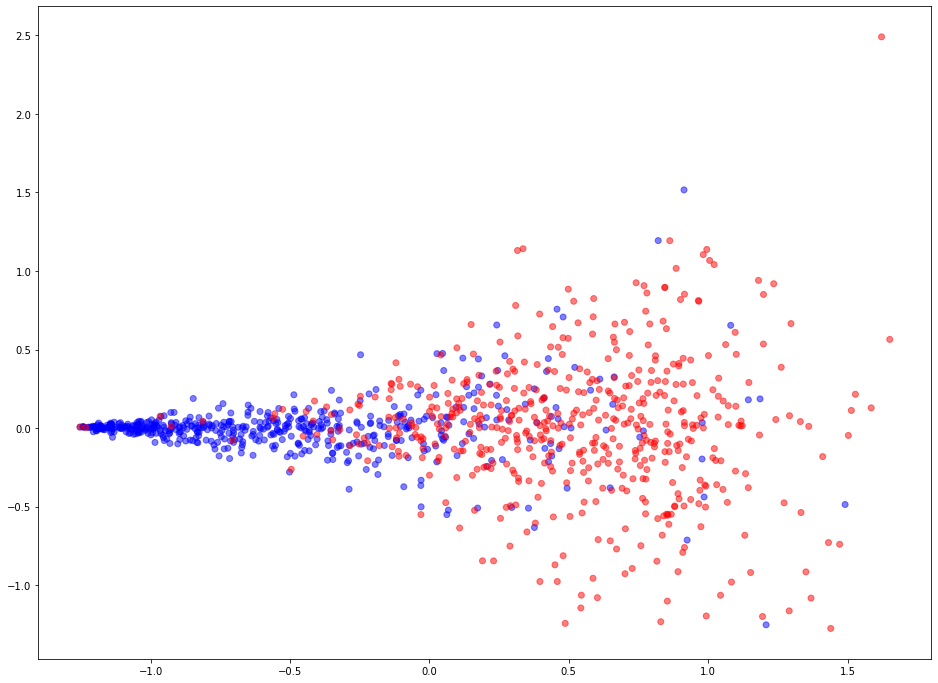

In [15]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)

This example has demonstrated how to use the `stellargraph` library to build a link prediction algorithm for homogeneous graphs using the Node2Vec, [1], representation learning algorithm.

<table><tr><td>Run the master version of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/random-walks/cora-lp-demo.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/random-walks/cora-lp-demo.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>